In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import nltk
import re
import swifter

nltk.download('stopwords')
from nltk.corpus import stopwords


print("CUDA available:", torch.cuda.is_available())
print("Using device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

c:\Users\Carmine\Development\natural-language-processing\feel-the-review\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
Using device: cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Carmine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load dataset
df = pd.read_json("data/Electronics_5.json", lines=True)

df = df.sample(frac=1/6, random_state=42).reset_index(drop=True)

# Filter & map ratings to sentiment
def map_sentiment(rating):
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

df['sentiment'] = df['overall'].apply(map_sentiment)
df['reviewText'] = df['reviewText'].astype(str)


In [ ]:
# Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text) # rimozione punteggiatura
    text = re.sub(r"\d+", "", text) # rimozione numeri
    text = " ".join([word for word in text.split() if word not in stopwords.words("english")])
    return text

df['cleaned'] = df['reviewText'].swifter.apply(clean_text)

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned'], df['sentiment'], test_size=0.2, stratify=df['sentiment'], random_state=42
)   


In [ ]:
# Show comparison of original and cleaned reviews
comparison_df = df[['reviewText', 'cleaned', 'sentiment']]
print(comparison_df.head(10))  
comparison_df.head(10)         

# Save cleaned reviews to JSON
comparison_df.to_json("data/cleaned_reviews.json", orient="records", lines=True)



In [3]:
# Load cleaned reviews from the saved JSON
df = pd.read_json("data/cleaned_reviews.json", lines=True)

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned'], df['sentiment'], test_size=0.2, stratify=df['sentiment'], random_state=42
)   


In [4]:
# === Traditional Models ===

# TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_texts)
X_test = tfidf.transform(test_texts)


In [5]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, train_labels)
lr_preds = lr.predict(X_test)

In [6]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, train_labels)
nb_preds = nb.predict(X_test)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.64      0.68     25835
     neutral       0.42      0.09      0.15     16820
    positive       0.90      0.98      0.94    181998

    accuracy                           0.87    224653
   macro avg       0.68      0.57      0.59    224653
weighted avg       0.84      0.87      0.85    224653



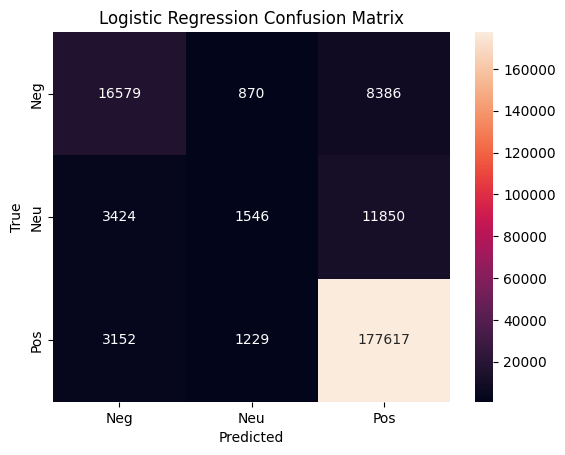


Naive Bayes Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.28      0.41     25835
     neutral       0.45      0.00      0.01     16820
    positive       0.84      1.00      0.91    181998

    accuracy                           0.84    224653
   macro avg       0.70      0.43      0.44    224653
weighted avg       0.81      0.84      0.79    224653



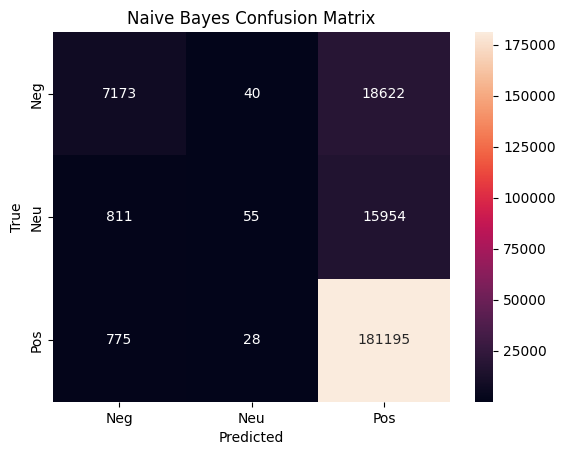

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def evaluate_model(name, preds):
    print(f"\n{name} Classification Report:")
    print(classification_report(test_labels, preds))
    cm = confusion_matrix(test_labels, preds, labels=["negative", "neutral", "positive"])
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Neg", "Neu", "Pos"], yticklabels=["Neg", "Neu", "Pos"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate_model("Logistic Regression", lr_preds)
evaluate_model("Naive Bayes", nb_preds)

# === Transformer-based Model ===

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

In [8]:
# Encode labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentiment'].map(label_map)

# Prepare dataset
tokenized_data = tokenizer(list(df['reviewText']), padding=True, truncation=True, return_tensors='pt')
dataset = Dataset.from_dict({
    'input_ids': tokenized_data['input_ids'],
    'attention_mask': tokenized_data['attention_mask'],
    'label': df['label']
})
dataset = dataset.train_test_split(test_size=0.2)

In [9]:
model.to("cuda")

# Define Trainer
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    report_to="none",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    fp16=True,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
)

trainer.train()

# Evaluate BERT model
bert_preds = trainer.predict(dataset['test']).predictions.argmax(-1)
bert_labels = dataset['test']['label']
print("\nDistilBERT Classification Report:")
print(classification_report(bert_labels, bert_preds, target_names=["negative", "neutral", "positive"]))

Epoch,Training Loss,Validation Loss
1,0.242300,0.226859
2,0.199000,0.222923



DistilBERT Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.84      0.83     25983
     neutral       0.53      0.41      0.47     16850
    positive       0.96      0.97      0.97    181820

    accuracy                           0.92    224653
   macro avg       0.77      0.74      0.75    224653
weighted avg       0.91      0.92      0.91    224653

